In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
import rascals

rascals.setupOorb()
#config = rascals.Config()

In [3]:
DATABASE = "../data/msst_survey.db"
con = sql.connect(DATABASE)

**Notes**

_On MJDs and propagation intervals:_

It is important that this algorithm works with exposure times and not nights. This is actually a little trickier than it sounds because the dataset has been simplified to just having a single exposure time for each individual night. 

In the general case, we have a series of observations, at different exposure times $t_i$ in fields centered at ($\alpha_i$, $\delta_i$). To make sure the algorithm works "ground-up" using exposure times, one of the inputs for "rascalization" **needs** to be an array of exposure MJDs with varying intervals.




## Sections
[Plotting Code](#Plotting-Code)  
[Query Code](#Query-Code)  
[Class: Cell](#Class:-Cell)  
[Class: TestParticle](#Class:-TestParticle)  
[Function: rascalize](#Function:-rascalize)  
[Example](#Example)

#### Plotting Code

In [4]:
def _setAxes(ax, coordinateSystem):
    """
    Helper function to set axes limits depending on the coordinate system.
    
    """
    if coordinateSystem == "equatorialAngular":
        ax.set_xlabel(r"$\alpha$ [deg]")
        ax.set_ylabel(r"$\delta$ [deg]")
    elif coordinateSystem == "eclipticAngular":
        ax.set_xlabel(r"$\lambda$ [deg]")
        ax.set_ylabel(r"$\beta$ [deg]")
    elif coordinateSystem == "gnomonic":
        ax.set_xlabel(r"$\theta_X$ [deg]")
        ax.set_ylabel(r"$\theta_Y$ [deg]")
    else:
        raise ValueError("coordinateSystem should be one of: 'equatorialAngular', 'eclipticAngular', 'tangentPlane'")
    ax.set_aspect("equal")
    return

def plotCell(cell,
             coordinateSystem="equatorialAngular",
             scatterKwargs={"s":0.05}):
        
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = cell.observations["RA_deg"].values, 
        y = cell.observations["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = cell.observationst["lon_deg"].values, 
        y = cell.observations["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    #ax.set_xlim(*cell.xRange)
    #ax.set_ylim(*cell.yRange)
    
    if cell.shape == "circle":
        cell_p = plt.Circle((cell.center[0], cell.center[1]), np.sqrt(cell.area / np.pi), color="r", fill=False)
    elif cell.shape == "square":
        half_side = np.sqrt(fieldArea) / 2
        cell_p = plt.Rectangle((cell.center[0] - half_side, cell.center[1] - half_side), 2 * half_side, 2 * half_side, color="r", fill=False)
    else: 
        raise ValueError("Cell.shape should be one of 'square' or 'circle'")
    ax.add_artist(cell_p)
    ax.grid()
    return
    
def plotNight(night,
              cell=None,
              coordinateSystem="equatorialAngular",
              scatterKwargs={"s":0.05},
              scatterXlims=(0, 360),
              scatterYlims=(-90, 90)):
    
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = night["RA_deg"].values, 
        y = night["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = night["lon_deg"].values, 
        y = night["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    ax.set_xlim(scatterXlims)
    ax.set_ylim(scatterYlims)

    if cell is not None:
        cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
        ax.add_artist(cell_p)

    ax.grid()
    return

def plotRascals(dataframe, colorByObject=False, usePlotly=True, returnFig=False):
    if usePlotly is True:
        data = []
        if colorByObject is True:
            for name in dataframe["name"].unique():
                obj = dataframe[dataframe["name"] == name]
                trace = plotly.graph_objs.Scatter(
                    x=obj["theta_x_deg"],
                    y=obj["theta_y_deg"],
                    name=name,
                    mode="lines+markers",
                    marker=dict(size=2,
                                line=dict(width=2))
                )
                data.append(trace)
        else:
            trace = plotly.graph_objs.Scatter(
                x=dataframe["theta_x_deg"],
                y=dataframe["theta_y_deg"],
                mode="markers",
                text=dataframe["name"],
                marker=dict(size=2)
            )
            data.append(trace)
            
        layout = dict(
            width=550,
            height=550,
            autosize=False,
            title="",
            scene=dict(
                xaxis=dict(
                    title="Theta_X [deg]",
                ),
                yaxis=dict(
                    title="Theta_Y [deg]",
                ),
                aspectratio = dict(x=1, y=1)))
        
        fig = plotly.graph_objs.Figure(data=data, layout=layout)
        plotly.offline.iplot(fig)
   
    else:
        fig, ax = plt.subplots(1, 1, dpi=200)
        if colorByObject is True:
            a, b = np.unique(dataframe["name"].values, return_inverse=True)
            hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())
            c = hex_map[b]
            ax.text(-0.018, 0.016, "Num Objects: {}".format(len(a)), fontsize=8)
        else:
            c = "blue"

        dataframe.plot(x="theta_x_deg", y="theta_y_deg", kind="scatter", c=c, s=0.5, ax=ax)
        _setAxes(ax, "gnomonic")
    
    if returnFig is True:
        if usePlotly is True:
            return fig
        else: 
            return fig, ax

def plotRascals3D(dataframe, colorByObject=False):
    
    data = []
    if colorByObject is True:
        for name in dataframe["name"].unique():
            obj = dataframe[dataframe["name"] == name]
            trace = plotly.graph_objs.Scatter3d(
                x=obj["theta_x_deg"],
                y=obj["theta_y_deg"],
                z=obj["exp_mjd"] - dataframe["exp_mjd"].min(),
                name=name,
                mode="lines+markers",
                marker=dict(size=2,
                            line=dict(width=4))
            )
            data.append(trace)
    else:
        trace = plotly.graph_objs.Scatter3d(
            x=dataframe["theta_x_deg"],
            y=dataframe["theta_y_deg"],
            z=dataframe["exp_mjd"] - dataframe["exp_mjd"].min(),
            mode="markers",
            marker=dict(size=2)
            )
        data.append(trace)

    layout = dict(
        width=800,
        height=550,
        autosize=False,
        title="",
        scene=dict(
            xaxis=dict(
                title="Theta_X [deg]",
            ),
            yaxis=dict(
                title="Theta_Y [deg]",
            ),
            zaxis=dict(
                title="Days [MJD]",
            ),
            aspectratio = dict(x=1, y=1, z=1)))

    fig = plotly.graph_objs.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

#### Rascals Code

In [5]:
from rascals import createQuery
from rascals import queryNight
from rascals import queryCell
from rascals import getObservations
from rascals import Cell
from rascals import TestParticle
from rascals import rascalize
from rascals import findClusters

#### Example

Let us see what a night of data looks like

In [6]:
nights = pd.read_sql("SELECT DISTINCT night FROM observations", con)

In [7]:
nights.values[15]

array([59755])

In [8]:
nights.values.T

array([[59740, 59741, 59742, 59743, 59744, 59745, 59746, 59747, 59748,
        59749, 59750, 59751, 59752, 59753, 59754, 59755, 59756, 59757,
        59758, 59759, 59760, 59761, 59762, 59763, 59764, 59765, 59766,
        59767, 59768, 59769]])

In [9]:
night1 = pd.read_sql("""SELECT * FROM observations WHERE night = 59740""", con)
night2 = pd.read_sql("""SELECT * FROM observations WHERE night = 59741""", con)

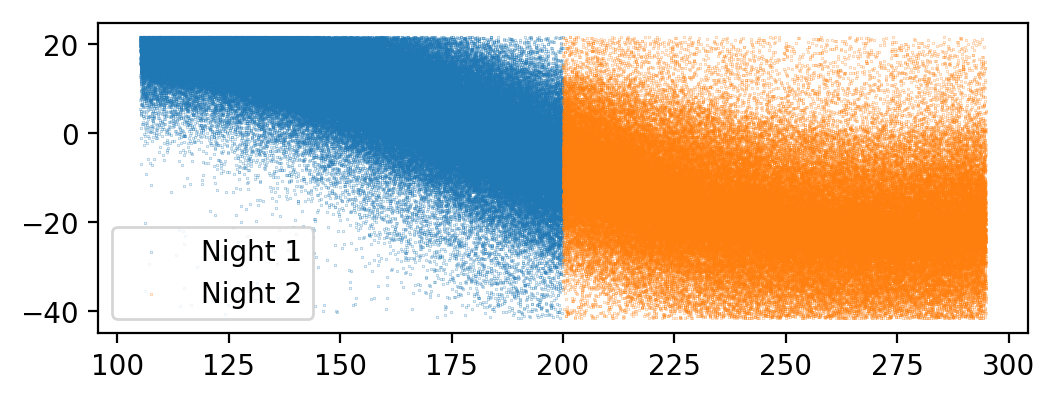

In [10]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*night1[["RA_deg", "Dec_deg"]].values.T, s=0.01, label="Night 1")
ax.scatter(*night2[["RA_deg", "Dec_deg"]].values.T, s=0.01, label="Night 2")
ax.legend()
ax.set_aspect("equal")

In [11]:
def calcEccentricAnomaly(v, e):
    return 2 * np.arctan2(np.sqrt(1 - e) * np.sin(v/2), np.sqrt(1 + e) * np.cos(v/2))

def calcMeanAnomaly(E, e):
    return E - e * np.sin(E)

def calcSemiMajorAxis(e, E, r):
    return r / (1 + e*np.cos(E))

Load some 'observations' into a dataframe

In [12]:
print("Creating index on object names...")
con.execute("CREATE INDEX designation_oorbeph ON observations (designation)")
print("Creating index on observation ids...")
con.execute("CREATE INDEX obsId_oorbeph ON observations (obsId)")
print("Creating index on nights...")
con.execute("CREATE INDEX night_oorbeph ON observations (night)")
print("Creating positional indexes...")
con.execute("CREATE INDEX ra_oorbeph ON observations (RA_deg)")
con.execute("CREATE INDEX dec_oorbeph ON observations (Dec_deg)")
con.execute("CREATE INDEX lon_oorbeph ON observations (HLon_deg)")
con.execute("CREATE INDEX lat_oorbeph ON observations (HLat_deg)")
con.execute("CREATE INDEX r_oorbeph ON observations (r_au)")
con.execute("CREATE INDEX delta_oorbeph ON observations (Delta_au)")
con.execute("CREATE INDEX visitId_oorbeph ON observations (visitId)")
con.commit()

Creating index on object names...
Creating index on observation ids...
Creating index on nights...
Creating positional indexes...


In [13]:
con.execute("CREATE INDEX visitId_noise100 ON noise_100 (visitId)")

In [14]:
con.execute("CREATE INDEX visitId_noise50 ON noise_50 (visitId)")
con.execute("CREATE INDEX visitId_noise200 ON noise_200 (visitId)")
con.execute("CREATE INDEX visitId_noise300 ON noise_300 (visitId)")

In [15]:
con.commit()

In [18]:
noise = pd.read_csv("../data/msst_survey_noise_.txt", sep=" ", index_col=False)

In [6]:
observations = pd.read_sql("""SELECT * FROM observations""", con)
                             # JOIN noise_50 ON (observations.visitId = noise_50.visitId)""", con)

In [7]:
observations

obsId  visitId  fieldId  fieldRA_deg  fieldDec_deg       exp_mjd  \
0              1        1        1   106.712809     20.041638  59739.937500   
1              2        1        1   106.712809     20.041638  59739.937500   
2              3        1        1   106.712809     20.041638  59739.937500   
3              4        1        1   106.712809     20.041638  59739.937500   
4              5        1        1   106.712809     20.041638  59739.937500   
5              6        1        1   106.712809     20.041638  59739.937500   
6              7        1        1   106.712809     20.041638  59739.937500   
7              8        1        1   106.712809     20.041638  59739.937500   
8              9        1        1   106.712809     20.041638  59739.937500   
9             10        1        1   106.712809     20.041638  59739.937500   
10            11        1        1   106.712809     20.041638  59739.937500   
11            12        1        1   106.712809     20.041638  59739.937500   
12            13        1        1   106.712809     20.041638  59739.937500   
13            14        1        1   106.712809     20.041638  59739.937500   
14            15        1        1   106.712809     20.041638  59739.937500   
15            16        1        1   106.712809     20.041638  59739.937500   
16            17        1        1   106.712809     20.041638  59739.937500   
17            18        1        1   106.712809     20.041638  59739.937500   
18            19        1        1   106.712809     20.041638  59739.937500   
19            20        1        1   106.712809     20.041638  59739.937500   
20            21        1        1   106.712809     20.041638  59739.937500   
21            22        1        1   106.712809     20.041638  59739.937500   
22            23        1        1   106.712809     20.041638  59739.937500   
23            24        1        1   106.712809     20.041638  59739.937500   
24            25        1        1   106.712809     20.041638  59739.937500   
25            26        1        1   106.712809     20.041638  59739.937500   
26            27        1        1   106.712809     20.041638  59739.937500   
27            28        1        1   106.712809     20.041638  59739.937500   
28            29        1        1   106.712809     20.041638  59739.937500   
29            30        1        1   106.712809     20.041638  59739.937500   
...          ...      ...      ...          ...           ...           ...   
5152596  5152597    17998     1198   293.287191     13.717082  59769.352083   
5152597  5152598    17999     1199   293.287191     16.879360  59769.352778   
5152598  5152599    17999     1199   293.287191     16.879360  59769.352778   
5152599  5152600    17999     1199   293.287191     16.879360  59769.352778   
5152600  5152601    17999     1199   293.287191     16.879360  59769.352778   
5152601  5152602    17999     1199   293.287191     16.879360  59769.352778   
5152602  5152603    17999     1199   293.287191     16.879360  59769.352778   
5152603  5152604    17999     1199   293.287191     16.879360  59769.352778   
5152604  5152605    17999     1199   293.287191     16.879360  59769.352778   
5152605  5152606    17999     1199   293.287191     16.879360  59769.352778   
5152606  5152607    17999     1199   293.287191     16.879360  59769.352778   
5152607  5152608    17999     1199   293.287191     16.879360  59769.352778   
5152608  5152609    17999     1199   293.287191     16.879360  59769.352778   
5152609  5152610    17999     1199   293.287191     16.879360  59769.352778   
5152610  5152611    17999     1199   293.287191     16.879360  59769.352778   
5152611  5152612    17999     1199   293.287191     16.879360  59769.352778   
5152612  5152613    18000     1200   293.287191     20.041638  59769.353472   
5152613  5152614    18000     1200   293.287191     20.041638  59769.353472   
5152614  5152615    18000     1200   293.287191     20.041638

In [19]:
noise.to_sql("noise_300", con, if_exists="append", index=False)

In [8]:
raRange = [50, 100]
decRange = [-30, -10]
mjdRange = [59582, 59582 + 30]
observations = getObservations(raRange, decRange, mjdRange, con)

Found 24203 observations.


Define an initial cell

In [ ]:
cell = Cell([75, -10], 1.0, 59582, dataframe=observations)
cell.getObservations()

In [10]:
plot3D(observations, includeObserver=True)

In [32]:
observations["obj_dx/dt_au_p_day"]

0       -0.010081
1       -0.010098
2       -0.010115
3       -0.010131
4       -0.010147
5       -0.010163
6       -0.010179
7       -0.010195
8       -0.010210
9       -0.010225
10      -0.010240
11      -0.010255
12      -0.010270
13      -0.010284
14      -0.010298
15      -0.010312
16      -0.010326
17      -0.010339
18      -0.010352
19      -0.012331
20      -0.012327
21      -0.012323
22      -0.012318
23      -0.012312
24      -0.012306
25      -0.012300
26      -0.012293
27      -0.012286
28      -0.012278
29      -0.012269
           ...   
24173   -0.013173
24174   -0.013151
24175   -0.015994
24176   -0.015978
24177   -0.015960
24178   -0.015941
24179   -0.015921
24180   -0.015900
24181   -0.015878
24182   -0.015854
24183   -0.015829
24184   -0.015803
24185   -0.015776
24186   -0.015748
24187   -0.015719
24188   -0.015688
24189   -0.015657
24190   -0.015624
24191   -0.015591
24192   -0.015556
24193   -0.015520
24194   -0.015484
24195   -0.015446
24196   -0.015408
24197   -0

In [30]:
plot3D(observations[observations["night"] == 59590], includeObserver=True)

In [19]:
cell = Cell([75, -10], 1.0, 59582, dataframe=observations)
cell.getObservations()

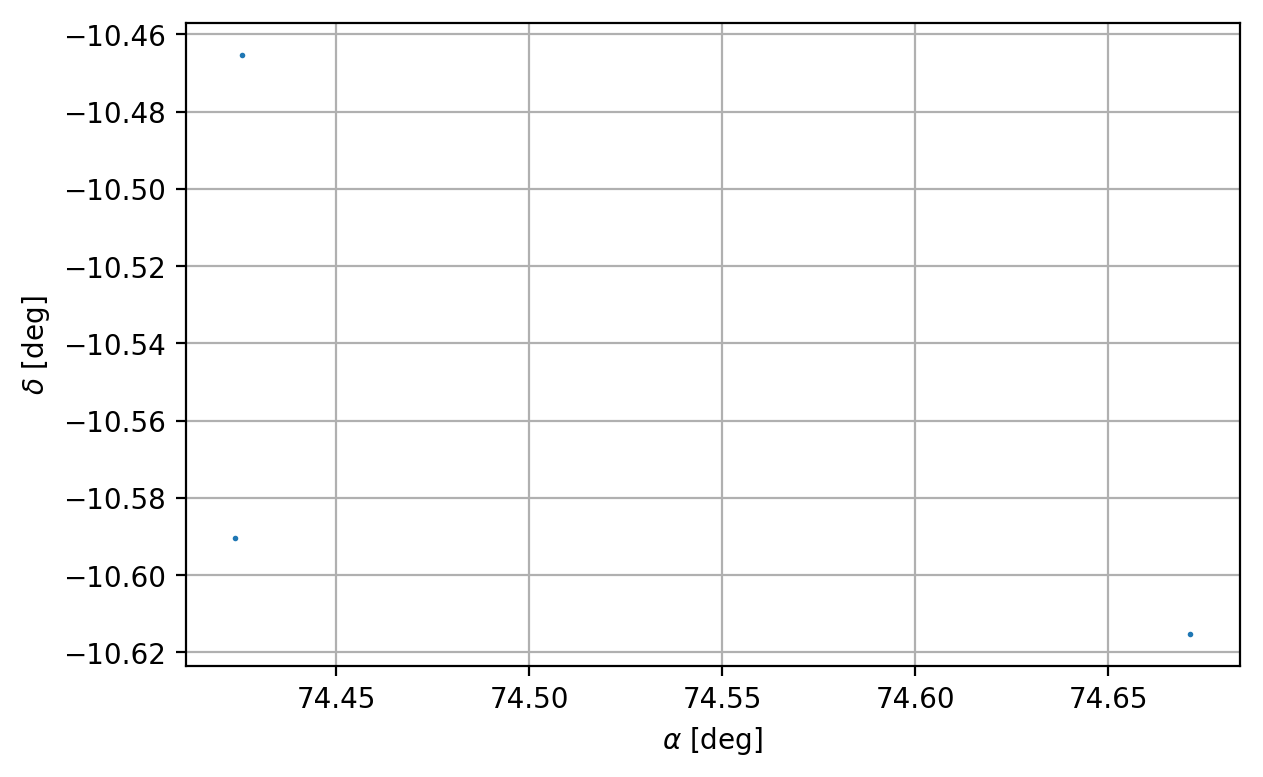

In [20]:
plotCell(cell, scatterKwargs={"s": 1})

In [21]:
print("r [AU]:\n min: {}\n max: {}\n median: {}".format(cell.observations["r_au"].min(),
                                                        cell.observations["r_au"].max(),
                                                        cell.observations["r_au"].median()))

r [AU]:
 min: 2.0294996633
 max: 3.8139299559
 median: 2.2461041795


In [22]:
cell.observations

obs_id    exp_mjd  night     RA_deg    Dec_deg  obs_x_au  obs_y_au  \
10979  15635039  59582.173  59582  74.425539 -10.465370 -0.211947  0.960252   
11789  16280118  59582.173  59582  74.423925 -10.590422 -0.211947  0.960252   
15240  18384026  59582.173  59582  74.671076 -10.615353 -0.211947  0.960252   

       obs_z_au        mag   name  Delta_au      r_au  obj_x_au  obj_y_au  \
10979 -0.000078  20.525217  o4357  1.202529  2.029500  0.105549  1.918475   
11789 -0.000078  20.462568  K06P0  1.431848  2.246104  0.165980  2.099468   
15240 -0.000078  22.192440  K14Qe  3.042967  3.813930  0.578724  3.383738   

       obj_z_au  obj_dx/dt_au_p_day  obj_dy/dt_au_p_day  obj_dz/dt_au_p_day  
10979 -0.653593           -0.012159            0.000898           -0.003677  
11789 -0.780812           -0.010583            0.004823            0.001733  
15240 -1.661764           -0.007296            0.002458            0.000662

In [23]:
# For now lets take the object which has the median barycentric distance, lets also grab its velocity
real_object = cell.observations[cell.observations["name"] == "K06P0"]
velocity_ec_cart = real_object[["obj_dx/dt_au_p_day", "obj_dy/dt_au_p_day", "obj_dz/dt_au_p_day"]].values[0]
x_e = real_object[["obs_x_au","obs_y_au", "obs_z_au"]].values[0]
r = real_object["r_au"].values[0]
mjd = real_object["exp_mjd"].values[0]

In [24]:
cell = Cell([75, -10], 1.0, 59582, dataframe=observations)
particle = TestParticle(cell.center, r, velocity_ec_cart, x_e, mjd)
mjds = observations["exp_mjd"].unique()

In [36]:
rRange = [1.5, 5.0]
rStep = 0.1

In [37]:
from astropy import constants as c
from astropy import units as u


In [58]:
T = np.sqrt((r * u.AU)**3 / (c.G * u.M_sun / (4 * np.pi**2)))
omega = (2 * np.pi * r * u.AU / T).to(u.AU / u.d)

In [59]:
omega

<Quantity 0.011478007215713328 AU / d>

In [60]:
np.sum(v**2)

0.022956014431426655

In [80]:
w = np.array([0, 0, omega.value])

In [84]:
np.cross(w, particle.x_a)

array([-0.0241707 ,  0.00173743,  0.        ])

In [83]:
velocity_ec_cart

array([-0.01058286,  0.00482281,  0.00173255])

In [42]:
np.sqrt((omega/2)**2 + (omega/2)**2)

<Quantity 0.008116176736739018 AU / d>

In [66]:
particle.x_a

array([-2.26937309, -0.03249908, -0.42773512])

In [29]:
(np.sqrt(c.G * u.M_sun / (2.5 * u.AU))).to(u.AU / u.day)

<Quantity 0.010879562641799125 AU / d>

In [30]:
particle.velocity_ec_cart

array([-0.00080995, -0.01203773, -0.00112666])

In [24]:
np.sqrt(np.sum(particle.velocity_ec_cart**2))

0.012117437012410935

In [20]:
np.arange(rRange[0], rRange[1] + rStep, rStep)

array([ 1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,
        2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,
        3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,
        4.8,  4.9,  5. ])

In [85]:
omega

<Quantity 0.011319228054398 AU / d>

In [87]:
velocity_ec_cart

array([-0.00080995, -0.01203773, -0.00112666])

In [86]:
np.sqrt((omega/np.sqrt(2))**2 + (omega/np.sqrt(2))**2 )

<Quantity 0.011319228054398 AU / d>

In [89]:
p = rascalize(cell, [1.0, 4.0], 0.1, mjds)

TypeError: __init__() missing 1 required positional argument: 'mjd'

In [90]:
def rascalize(cell, rRange, rStep, mjds, mjd_range=0.5, includeEquatorialProjection=True, verbose=True):
    
    # Set up an array of heliocentric distances
    rs = np.arange(rRange[0], rRange[1] + rStep, rStep)
    
    particles = []
    for r in rs:
        particle = TestParticle(cell.center, r, x_e, mjds[0])
        particles.append(particle)
        
    
    return particles



def rascalizeSingleParticle(cell, particle, mjds, mjd_range=0.5, includeEquatorialProjection=True, verbose=True):
    # If initial doesn't have observations loaded,
    # get them
    if cell.observations is None:
        cell.getObservations()
    
    # Prepare transformation matrices
    particle.prepare(verbose=verbose)
    
    # Apply tranformations to observations
    particle.apply(cell, verbose=verbose)
    
    # Add initial cell and particle to lists
    cells = [cell]
    particles = [particle]
    
    if includeEquatorialProjection is True:
            cell.observations["theta_x_eq_deg"] = cell.observations["RA_deg"] - particle.coords_eq_ang[0]
            cell.observations["theta_y_eq_deg"] = cell.observations["Dec_deg"] - particle.coords_eq_ang[1]
    
    # Initialize final dataframe and add observations
    final_df = pd.DataFrame()
    final_df = pd.concat([cell.observations, final_df])
    
    for mjd_f in mjds[1:]:
        oldCell = cells[-1]
        oldParticle = particles[-1]
        
        # Propagate particle to new mjd
        propagated = propagateTestParticle(oldParticle.x_a,
                                           oldParticle.velocity_ec_cart,
                                           oldParticle.mjd,
                                           mjd_f,
                                           verbose=verbose)
        # Get new equatorial coordinates
        new_coords_eq_ang = propagated[["RA_deg", "Dec_deg"]].values[0]
        
        # Get new barycentric distance
        new_r = propagated["r_au"].values[0]
        
        # Get new velocity in ecliptic cartesian coordinates
        new_velocity_ec_cart = propagated[["HEclObj_dX/dt_au_p_day",
                                           "HEclObj_dY/dt_au_p_day",
                                           "HEclObj_dZ/dt_au_p_day"]].values[0]
        
        # Get new location of observer
        new_x_e = propagated[["HEclObsy_X_au",
                              "HEclObsy_Y_au",
                              "HEclObsy_Z_au"]].values[0]
        
        # Get new mjd (same as mjd_f)
        new_mjd = propagated["mjd_utc"].values[0]

        # Define new cell at new coordinates
        newCell = Cell(new_coords_eq_ang,
                       oldCell.radius,
                       new_mjd,
                       dataframe=oldCell.dataframe)
        
        # Get the observations in that cell
        newCell.getObservations()
        
        # Define new particle at new coordinates
        newParticle = TestParticle(new_coords_eq_ang,
                                   new_r,
                                   new_x_e,
                                   new_mjd,
                                   velocity_ec_cart=new_velocity_ec_cart)
        
        # Prepare transformation matrices
        newParticle.prepare(verbose=verbose)
       
        # Apply tranformations to new observations
        newParticle.apply(newCell, verbose=verbose)
        
        if includeEquatorialProjection is True:
            newCell.observations["theta_x_eq_deg"] = newCell.observations["RA_deg"] - newParticle.coords_eq_ang[0]
            newCell.observations["theta_y_eq_deg"] = newCell.observations["Dec_deg"] - newParticle.coords_eq_ang[1]
        
        # Add observations to final dataframe
        final_df = pd.concat([newCell.observations, final_df])
    
        # Append new cell and particle to lists
        cells.append(newCell)
        particles.append(newParticle)
        
    final_df.sort_values(by="exp_mjd", inplace=True)
        
    return final_df, cells, particles

def clusterVelocity(obs_ids, theta_x, theta_y, dt, vx, vy, eps=0.005, min_samples=3):
    xx = theta_x - vx * dt
    yy = theta_y - vy * dt
    X = np.vstack([xx, yy]).T  
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    
    clusters = db.labels_[np.where(db.labels_ != -1)[0]]
    cluster_ids = []
    
    if len(clusters) != 0:
        for cluster in np.unique(clusters):
            cluster_ids.append(obs_ids[np.where(db.labels_ == cluster)[0]])
    else:
        cluster_ids = -1
    
    del db
    return cluster_ids
           
def _clusterVelocity(vx, vy,
                     obs_ids=None,
                     theta_x=None,
                     theta_y=None,
                     dt=None,
                     eps=None,
                     min_samples=None):
    return clusterVelocity(obs_ids,
                           theta_x,
                           theta_y,
                           dt,
                           vx,
                           vy,
                           eps=eps,
                           min_samples=min_samples) 

def findClusters(detections, gridpoints=10000, threads=10, eps=0.005, min_samples=3, verbose=True):
    
    # Extract useful quantities
    obs_ids = detections["obs_id"].values
    theta_x = detections["theta_x_deg"].values
    theta_y = detections["theta_y_deg"].values
    mjd = detections["exp_mjd"].values
    truth = detections["name"].values

    # Select detections in first exposure
    first = np.where(mjd == mjd.min())[0]
    theta_x0 = theta_x[first]
    theta_y0 = theta_y[first]
    mjd0 = mjd[first][0]
    dt = mjd - mjd0

    # Grab remaining detections
    remaining = np.where(mjd != mjd.min())[0]
    
    # Create min, max velocity variables
    vx_max = 0
    vx_min = 0
    vy_max = 0
    vy_min = 0
    
    # Calculate the velocity from every detection in the first exposure
    # to every detection in the following exposures. Keep the max and min
    # for both x and y.
    if verbose:
        print("Calculating velocity ranges...")
        
    for i in first:
        vx = (theta_x[remaining] - theta_x0[i]) / dt[remaining]
        vy = (theta_y[remaining] - theta_y0[i]) / dt[remaining]
        if np.min(vx) < vx_min:
            vx_min = np.min(vx)
        if np.max(vx) > vx_max:
            vx_max = np.max(vx)
        if np.min(vy) < vy_min:
            vy_min = np.min(vy)
        if np.max(vy) > vy_max:
            vy_max = np.max(vy)
            
    if verbose:
        print("Maximum possible x velocity range: {:.4e} to {:.4e}".format(vx_min, vx_max))
        print("Maximum possible y velocity range: {:.4e} to {:.4e}".format(vy_min, vy_max))
        
    # Define velocity grid
    possible_vx = np.linspace(vx_min, vx_max, num=int(np.sqrt(gridpoints)))
    possible_vy = np.linspace(vy_min, vy_max, num=int(np.sqrt(gridpoints)))
    vxx, vyy = np.meshgrid(possible_vx, possible_vy)
    vxx = vxx.flatten()
    vyy = vyy.flatten()
    
    if verbose:
        print("Running velocity space clustering.")
    
    possible_clusters = []
    if threads > 1:
        if verbose:
            print("Using {} threads".format(threads))
        p = mp.Pool(threads)
        possible_clusters = p.starmap(partial(_clusterVelocity, 
                                              obs_ids=obs_ids,
                                              theta_x=theta_x,
                                              theta_y=theta_y,
                                              dt=dt,
                                              eps=eps,
                                              min_samples=min_samples),
                                              zip(vxx.T, vyy.T))
        p.close()
    else:
        possible_clusters = []
        for vxi, vyi in zip(vxx, vyy):
            possible_clusters.append(_clusterVelocity(vxi, vyi))
    
    # Clean up returned arrays and remove empty cases
    populated_clusters = []
    populated_cluster_velocities = []
    for cluster, vxi, vyi in zip(possible_clusters, vxx, vyy):
        if type(cluster) == int:
            continue
        else:
            populated_clusters.append(cluster)
            populated_cluster_velocities.append([vxi, vyi])
            
    if verbose:
        print("Found {} cluster groups.".format(len(populated_clusters)))

    return populated_clusters, populated_cluster_velocities, dt

In [25]:
rascals_df, cells, particles = rascalize(cell, particle, mjds, verbose=False)

../rascals/particle.py:67: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

../rascals/particle.py:72: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

../rascals/image_processing.py:51: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

../rascals/image_processing.py:59: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

../rascals/image_processing.py:64: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

../rascals/particle.py:67: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

../rascals/particle.py:72: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

../rascals/image_processing.py:51: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

../rasca

In [26]:
plotRascals(rascals_df)

In [28]:
plotRascals(rascals_df, colorByObject=True)

In [20]:
plotRascals3D(rascals_df2, colorByObject=True)

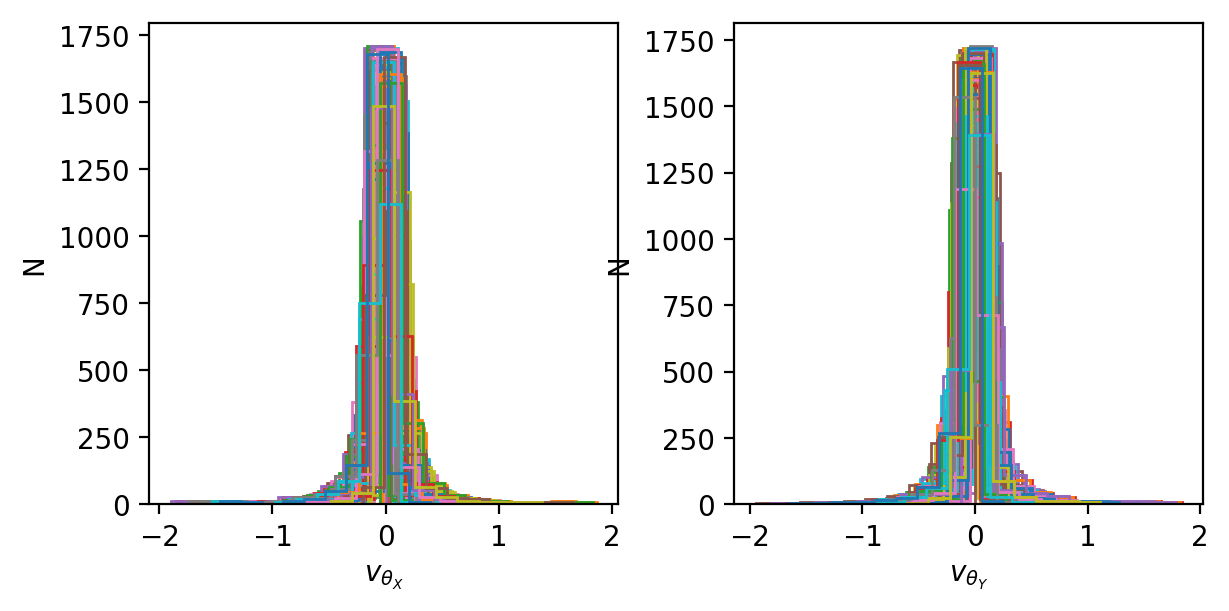

In [20]:
theta_x = rascals_df["theta_x_deg"].values
theta_y = rascals_df["theta_y_deg"].values
mjd = rascals_df["exp_mjd"].values
truth = rascals_df["name"].values

# Select detections in first exposure:
first = np.where(mjd == mjd.min())[0]
theta_x0 = theta_x[first]
theta_y0 = theta_y[first]
mjd0 = mjd[first][0]
dt = mjd - mjd0

# Grab remaining detections
remaining = np.where(mjd != mjd.min())[0]

vx = {}
vy = {}
for i in range(len(first)):
    vx[i] = (theta_x[remaining] - theta_x0[i]) / dt[remaining]
    vy[i] = (theta_y[remaining] - theta_y0[i]) / dt[remaining]
    
fig, ax = plt.subplots(1, 2, dpi=200)
fig.set_size_inches(6, 3)
fig.tight_layout()

for k, v in vx.items():
    ax[0].hist(v, histtype="step", bins=10)
ax[0].set_xlabel(r"$v_{\theta_X}$")

for k, v in vy.items():
    ax[1].hist(v, histtype="step", bins=10)
ax[1].set_xlabel(r"$v_{\theta_Y}$")

for a in ax:
    a.set_ylabel("N");

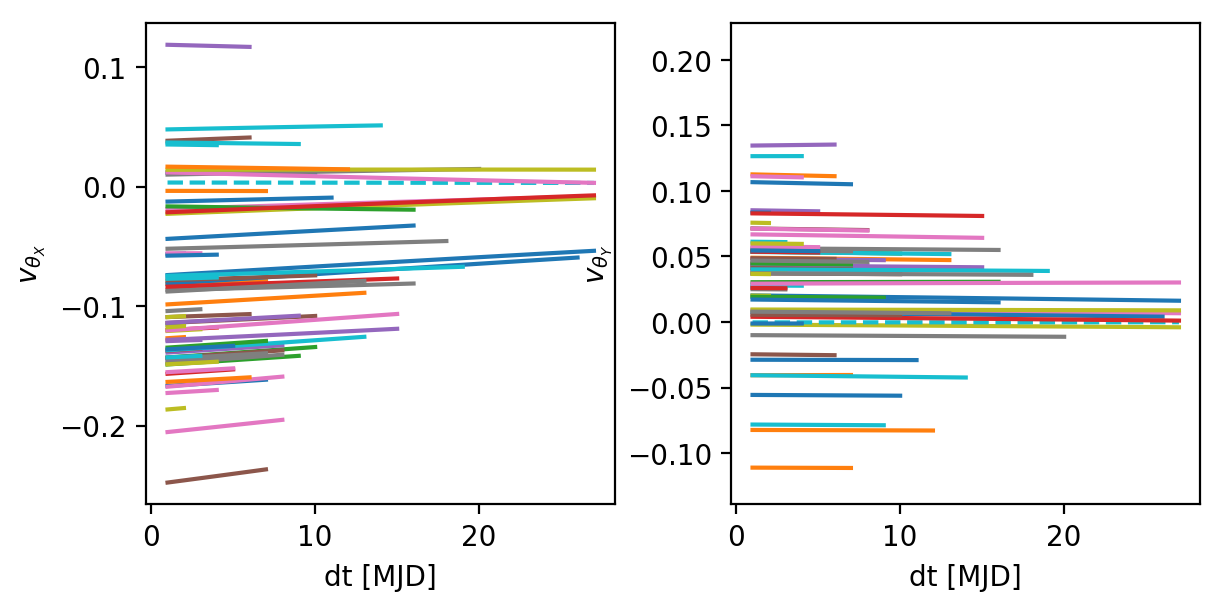

In [21]:
fig, ax = plt.subplots(1, 2, dpi=200)
fig.set_size_inches(6, 3)
fig.tight_layout()

uniqueObjects = rascals_df[rascals_df["exp_mjd"] == rascals_df["exp_mjd"].min()]["name"].unique()
for name in uniqueObjects:
    singleObject = rascals_df[(rascals_df["name"] == name)]
    theta_x = singleObject["theta_x_deg"].values
    theta_y = singleObject["theta_y_deg"].values
    mjd = singleObject["exp_mjd"].values
    
    first = np.where(mjd == mjd.min())[0]
    theta_x0 = theta_x[first]
    theta_y0 = theta_y[first]
    mjd0 = mjd[first][0]
    dt = mjd - mjd0
    
    remaining = np.where(mjd != mjd.min())[0]

    vx = (theta_x[remaining] - theta_x0) / dt[remaining]
    vy = (theta_y[remaining] - theta_y0) / dt[remaining]
    
    if name == "U3160":
        ls = "--"
    else:
        ls = "-"
        
    ax[0].plot(dt[remaining], vx, ls=ls)
    ax[0].set_ylabel(r"$v_{\theta_X}$")
    ax[1].plot(dt[remaining], vy, ls=ls)
    ax[1].set_ylabel(r"$v_{\theta_Y}$")
    
for a in ax:
    a.set_xlabel("dt [MJD]")


In [38]:
populated_clusters, populated_cluster_velocities, dt = findClusters(rascals_df, gridpoints=10000)

Calculating velocity ranges...
Maximum possible x velocity range: -1.8992e+00 to 1.8717e+00
Maximum possible y velocity range: -1.9471e+00 to 1.8396e+00
Running velocity space clustering.
Using 10 threads
Found 996 cluster groups.


In [39]:
def analyzeClusters(clusters, velocities, detections, min_detections_accepted=3, min_samples=3):
    
    true_clusters = []
    true_cluster_velocities = []
    partial_clusters = []
    partial_cluster_velocities = []
    found_objects = []
    partial_objects = []
    false_clusters = []
    
    all_names = detections["name"].values
    all_unique_names, all_unique_counts = np.unique(all_names, return_counts=True)
    unique_names_enough_samples = len(np.where(all_unique_counts >= min_samples)[0])

    print("Number of unique objects: {}".format(len(all_unique_names)))
    print("Number of unique objects with at least {} detections: {}".format(min_samples, unique_names_enough_samples))
    
    for c, v in zip(clusters, velocities):
        for individual_cluster in c:
            names = detections[detections["obs_id"].isin(individual_cluster)]["name"].values
            unique_names, unique_name_counts = np.unique(names, return_counts=True)
            unique_names_thresh = unique_names[np.where(unique_name_counts >= min_detections_accepted)[0]]
            
            if len(unique_names) == 1 and unique_name_counts[0] >= min_samples: 
                true_clusters.append(c)
                found_objects.append(np.unique(unique_names[0]))
                true_cluster_velocities.append(v)
            if len(unique_names_thresh) == 1 and len(unique_names) != 1:
                partial_clusters.append(c)
                partial_objects.append(np.unique(unique_names_thresh[0]))
                partial_cluster_velocities.append(v)
            else:
                false_clusters.append(c)
    
    found_objects_count = len(np.unique(np.array(found_objects)))
    partial_found_objects_count = len(np.unique(np.array(partial_objects)))
    pure_partial_found_count = len(np.unique(np.concatenate([np.unique(np.array(partial_objects)), np.unique(np.array(found_objects))])))
    true_cluster_count = len(true_clusters)
    partial_cluster_count = len(partial_clusters)
    false_cluster_count = len(false_clusters)
    total_cluster_count = true_cluster_count + partial_cluster_count + false_cluster_count
   
    print("Number of unique objects found in pure clusters: {}".format(found_objects_count))
    print("Number of unique objects found in contaminated clusters: {}".format(partial_found_objects_count))
    print("Number of unique objects found: {}".format(pure_partial_found_count))
    print("Completeness (w/o partial): {}".format(found_objects_count / unique_names_enough_samples))
    print("Completeness (w/ partial): {}".format(pure_partial_found_count / unique_names_enough_samples))
    print("True Clusters: {}".format(true_cluster_count))
    print("Partial Clusters: {}".format(partial_cluster_count))
    print("False clusters: {}".format(false_cluster_count))
    print("Contamination: {}".format(false_cluster_count / total_cluster_count))
    return np.array(true_clusters), np.array(true_cluster_velocities), np.array(partial_clusters), np.array(partial_cluster_velocities), np.array(false_clusters)

In [40]:
true_clusters, true_cluster_velocities, partial_clusters, partial_cluster_velocities, false_clusters = analyzeClusters(populated_clusters, populated_cluster_velocities, rascals_df)

Number of unique objects: 214
Number of unique objects with at least 3 detections: 185
Number of unique objects found in pure clusters: 142
Number of unique objects found in contaminated clusters: 17
Number of unique objects found: 149
Completeness (w/o partial): 0.7675675675675676
Completeness (w/ partial): 0.8054054054054054
True Clusters: 206
Partial Clusters: 18
False clusters: 1218
Contamination: 0.8446601941747572


In [37]:
true_clusters

array([[array([17794150, 17794151, 17794152])],
       [array([17794150, 17794151, 17794152])],
       [array([3029460, 3029461, 3029462])], ...,
       [array([17991059, 17991060, 17991061])],
       [array([17991058, 17991059, 17991060])],
       [array([17991057, 17991058, 17991059])]], dtype=object)

In [41]:
rascals_df

obs_id    exp_mjd  night      RA_deg    Dec_deg  obs_x_au  \
1548313  22971468  59582.173  59582  199.195252 -19.874432 -0.211947   
488401    7225235  59582.173  59582  199.824402 -20.375146 -0.211947   
499811    7448063  59582.173  59582  200.619814 -19.765095 -0.211947   
518096    7748143  59582.173  59582  199.259011 -20.126846 -0.211947   
566139    8411822  59582.173  59582  199.587352 -20.001292 -0.211947   
567382    8431104  59582.173  59582  199.830407 -20.675432 -0.211947   
590050    8693364  59582.173  59582  200.594007 -19.955557 -0.211947   
609981    9026118  59582.173  59582  199.468032 -19.208027 -0.211947   
474642    7081054  59582.173  59582  199.634152 -20.293512 -0.211947   
631492    9397932  59582.173  59582  199.792117 -19.786006 -0.211947   
693551   10405184  59582.173  59582  200.437434 -19.916734 -0.211947   
710138   10641528  59582.173  59582  198.854438 -19.930168 -0.211947   
728035   10987178  59582.173  59582  199.035802 -20.260216 -0.211947   
728199   10987643  59582.173  59582  199.201697 -20.583178 -0.211947   
732948   11079837  59582.173  59582  199.370749 -20.557253 -0.211947   
765371   11536808  59582.173  59582  200.728208 -19.760184 -0.211947   
779200   11688057  59582.173  59582  200.332001 -20.489207 -0.211947   
640231    9577887  59582.173  59582  199.985791 -20.441333 -0.211947   
470867    7036445  59582.173  59582  199.896944 -19.101049 -0.211947   
444546    6669064  59582.173  59582  199.207571 -19.362197 -0.211947   
425358    6282091  59582.173  59582  199.473868 -19.140763 -0.211947   
30847      454339  59582.173  59582  198.976384 -19.475951 -0.211947   
52215      789449  59582.173  59582  199.667763 -18.960455 -0.211947   
72901     1139935  59582.173  59582  200.568024 -20.318549 -0.211947   
149744    2298188  59582.173  59582  199.740178 -20.608807 -0.211947   
154537    2352965  59582.173  59582  200.286241 -19.158899 -0.211947   
175197    2602732  59582.173  59582  200.440876 -20.494365 -0.211947   
227597    3428138  59582.173  59582  199.275967 -19.370203 -0.211947   
239296    3568568  59582.173  59582  199.557962 -19.044788 -0.211947   
308186    4630039  59582.173  59582  200.161126 -19.036095 -0.211947   
...           ...        ...    ...         ...        ...       ...   
1549022  22984546  59609.173  59609  206.406194 -25.012247 -0.632325   
1533888  22813705  59609.173  59609  207.573216 -25.025533 -0.632325   
1476588  21873537  59609.173  59609  207.540290 -24.139207 -0.632325   
1475827  21865136  59609.173  59609  207.471648 -24.785961 -0.632325   
1475460  21862067  59609.173  59609  206.234452 -25.296469 -0.632325   
1437258  21255273  59609.173  59609  206.773044 -25.530888 -0.632325   
1435266  21218290  59609.173  59609  207.867104 -25.343485 -0.632325   
1413395  20843531  59609.173  59609  206.808018 -24.167609 -0.632325   
1400701  20691042  59609.173  59609  206.986593 -24.393974 -0.632325   
1369008  20271302  59609.173  59609  206.993019 -25.040827 -0.632325   
1328688  19645505  59609.173  59609  207.679062 -25.656534 -0.632325   
1308373  19357546  59609.173  59609  206.417702 -25.660786 -0.632325   
938845   14097838  59609.173  59609  206.724356 -24.528800 -0.632325   
1302268  19299514  59609.173  59609  206.584850 -24.519444 -0.632325   
1222974  18156265  59609.173  59609  206.922410 -24.149153 -0.632325   
1219859  18093087  59609.173  59609  206.333123 -25.346608 -0.632325   
1205717  17940288  59609.173  59609  206.881656 -25.531417 -0.632325   
1166863  17329836  59609.173  59609  206.955256 -24.231738 -0.632325   
1145160  17049844  59609.173  59609  206.881164 -24.599052 -0.632325   
1144893  17047395  59609.173  59609  207.669740 -25.628931 -0.632325   
1142592  17002259  59609.173  59609  206.540865 -24.728355 -0.632325   
1126097  16779989  59609.173  59609  207.163101 -24.241440 -0.632325   
1107447  16565097  59609.173  59609  207.281375 -25.727456 -0.632325   
1105105  16538189  59609.173  59609  206.997530 -24

In [26]:
true_cluster_velocities

array([[ 0.08626607, -0.57875147],
       [ 0.08626607, -0.57496099],
       [ 0.53923048, -0.3399512 ],
       ..., 
       [ 0.10513959,  0.21724943],
       [ 0.10891429,  0.21724943],
       [ 0.112689  ,  0.21724943]])

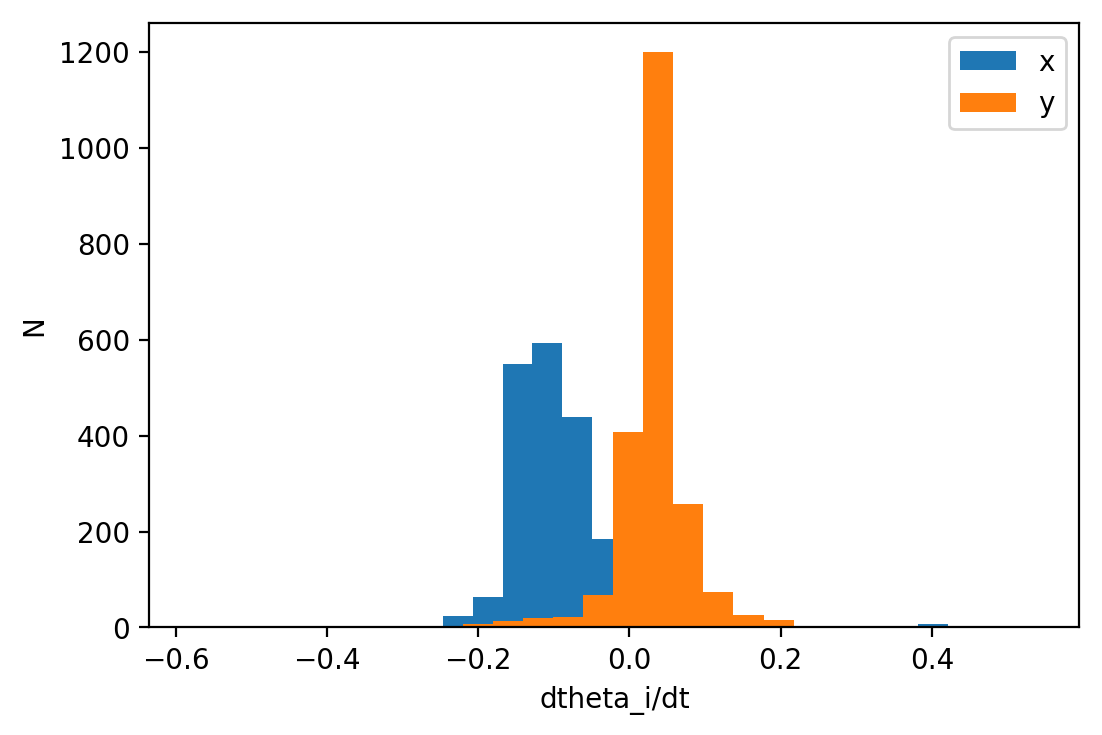

In [35]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.hist(true_cluster_velocities[:,0], bins=20, label="x")
ax.hist(true_cluster_velocities[:,1], bins=20, label="y")
ax.set_xlabel("dtheta_i/dt")
ax.set_ylabel("N")
ax.legend()

*** DO NOT RUN BELOW ***

*** DO NOT RUN BELOW ***

*** DO NOT RUN BELOW ***

In [ ]:

#a, b = np.unique(rascals_df["name"].values, return_inverse=True)
#hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())
#c = hex_map[b]
   
#fig, ax = plt.subplots(1, 1, dpi=150)
#ax.scatter(xx, yy, s=0.1, c=c)


possible_vx = np.linspace(-0.3, 0.15, num=10)
possible_vy = np.linspace(-0.15, 0.15, num=10)
vxx, vyy = np.meshgrid(possible_vx, possible_vy)
vxx = vxx.flatten()
vyy = vyy.flatten()

theta_x = rascals_df["theta_x_deg"].values
theta_y = rascals_df["theta_y_deg"].values
mjd = rascals_df["exp_mjd"].values
truth = rascals_df["name"].values

# Select detections in first exposure:
first = np.where(mjd == mjd.min())[0]
theta_x0 = theta_x[first]
theta_y0 = theta_y[first]
mjd0 = mjd[first][0]
dt = mjd - mjd0

# Grab remaining detections
remaining = np.where(mjd != mjd.min())[0]

velocitys = ["{:.2}, {:.2}".format(x, y) for x, y in zip(vxx, vyy)]
        
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

figure['layout']['height']= 800
figure['layout']['width'] = 800
figure['layout']['xaxis'] = { 'title': 'theta_X', 'range': [-10, 10]}
figure['layout']['yaxis'] = { 'title': 'theta_Y', 'range': [-10, 10]}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': velocitys[0],
    'plotlycommand': 'animate',
    'values': velocitys,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Velocity:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}


xx = theta_x[remaining] + vxx[0] * dt[remaining]
yy = theta_y[remaining] + vyy[0] * dt[remaining]

for name in np.unique(truth[remaining]):
    mask = np.where(truth[remaining] == name)[0]
    data_dict = {
        'x': xx[mask],
        'y': yy[mask],
        'mode': 'markers',
        'text': name,
        'marker': {
            'size': 3
        },
        'name': name
    }
    figure['data'].append(data_dict)
    

for v, vxii, vyii in zip(velocitys, vxx, vyy):
    xx = theta_x[remaining] + vxii * dt[remaining]
    yy = theta_y[remaining] + vyii * dt[remaining]
    
    frame = {'data': [], 'name': v}
    for name in np.unique(truth[remaining]):
        mask = np.where(truth[remaining] == name)[0]
        data_dict = {
                'x': xx[mask],
                'y': yy[mask],
                'mode': 'markers',
                'text': name,
                'marker': {
                    'size': 3
                },
                'name': name
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [v],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
         'transition': {'duration': 300}}
     ],
     'label': v,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

    

plotly.offline.plot(figure, filename="velocity.html")


In [ ]:
def animateRascals(cell, particle, mjds, r_range, r_step=0.5, colorByObject=True):
    
    
    ri = np.arange(r_range[0], r_range[1]+r_step, r_step)

    figure = {
        'data': [],
        'layout': {},
        'frames': []
    }

    figure['layout']['height']= 800
    figure['layout']['width'] = 800
    figure['layout']['xaxis'] = { 'title': 'theta_X'}
    figure['layout']['yaxis'] = { 'title': 'theta_Y'}
    figure['layout']['hovermode'] = 'closest'
    figure['layout']['sliders'] = {
        'args': [
            'transition', {
                'duration': 400,
                'easing': 'cubic-in-out'
            }
        ],
        'initialValue': ri[0],
        'plotlycommand': 'animate',
        'values': ri,
        'visible': True
    }
    figure['layout']['updatemenus'] = [
        {
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 500, 'redraw': False},
                             'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                    'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }
    ]
    
    sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'r:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
    }
 
    particle.r = ri[0]
    dataframe, cells, particles = rascalize(cell, particle, mjds, verbose=False)
    if colorByObject is True:
        for name in dataframe["name"].unique(): 
            obj = dataframe[dataframe["name"] == name]
            data_dict = {
                'x': obj["theta_x_deg"],
                'y': obj["theta_y_deg"],
                'mode': 'markers',
                'text': name,
                'marker': {
                    'size': 3,
                },
                'name': name
            }
            figure['data'].append(data_dict)
    else:
        obj = dataframe
        data_dict = {
            'x': obj["theta_x_deg"],
            'y': obj["theta_y_deg"],
            'mode': 'markers',
            'text': None,
            'marker': {
                'size': 3,
            },
            'name': None
        }
        figure['data'].append(data_dict)



    for r in ri:
        particle.r = r
        dataframe, cells, particles = rascalize(cell, particle, mjds, verbose=False)

        frame = {'data': [], 'name': r}
        if colorByObject is True:
            for name in dataframe["name"].unique(): 
                obj = dataframe[dataframe["name"] == name]
                data_dict = {
                    'x': obj["theta_x_deg"],
                    'y': obj["theta_y_deg"],
                    'mode': 'markers',
                    'text': name,
                    'marker': {
                        'size': 3,
        
                    },
                    'name': name
                }
                frame['data'].append(data_dict)
        else:
            obj = dataframe
            data_dict = {
                'x': obj["theta_x_deg"],
                'y': obj["theta_y_deg"],
                'mode': 'markers',
                'text': None,
                'marker': {
                    'size': 3,
                },
                'name': None
            }
            frame['data'].append(data_dict)
        
        figure['frames'].append(frame)
        slider_step = {'args': [
            [r],
            {'frame': {'duration': 300, 'redraw': False},
             'mode': 'immediate',
             'transition': {'duration': 300}}
         ],
         'label': r,
         'method': 'animate'}
        sliders_dict['steps'].append(slider_step)


    figure['layout']['sliders'] = [sliders_dict]

    plotly.offline.plot(figure, filename="heliocentric.html")
    return 

In [ ]:
cell = Cell([199.8, -19.8], 1.0, 59582, dataframe=observations)
particle = TestParticle(cell.center, 2.0, velocity_ec_cart, x_e, mjd)
mjds = observations["exp_mjd"].unique()
dataframe, cells, particles = rascalize(cell, particle, mjds, verbose=False)
animateRascals(cell, particle, mjds, [1.5, 3.0], r_step=0.05)